# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 3. Простой анализ данных.

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Телеграм не разрешает боту получать файлы более **20 Мб**. Если ваше решение весит больше, *заранее* разделите ноутбук на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания **используйте этот ноутбук в качестве основы, ничего не удаляя из него**. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Перед выполнением задания посмотрите презентацию по выполнению и оформлению домашних заданий с занятия 2.**

---

**Баллы за задание:**

<b><font color="blue">Легкая часть</font></b> (достаточно на "хор"):
* Задача 1 &mdash; 60 баллов

<b><font color="orange">Сложная часть</font></b> (необходимо на "отл"):
* Задача 2 &mdash; 80 баллов

---

In [1]:
# Bot check

# HW_ID: fpmi_ad3
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

### <font color="blue"><i>Легкая часть</i></font>


### Задача 1.

На занятии мы уже <a href="https://miptstats.github.io/courses/ad_fivt/titanik.html" target="_blank">начинали</a> работать с датасетом Титаник. Сейчас ваша задача &mdash; на основе простого анализа предоставленных данных получить некоторое приближенное правило определения, выжил пассажир или нет.

#### 1. Подготовка данных

Загрузите данные с помощью `pandas`.

In [3]:
df = pd.read_csv("train.csv", delimiter=',', index_col=0)
df.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

Изначально подумаем, что делать с пропусками:

In [4]:
df.isna().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Из всех признаков с пропусками нас интересует только возраст, и могло быть так, что девушки чаще не говорят свой возраст, нежели мужчины. 

Проверим это

In [5]:
age_na = df[df['Age'].isna()]
mal_na, fem_na = age_na['Sex'].value_counts()

mal, fem = df['Sex'].value_counts()
print('Доля мужчин без указанного возраста:', mal_na/mal, '\nДоля женщин без указанного возраста:', fem_na/fem)

Доля мужчин без указанного возраста: 0.21490467937608318 
Доля женщин без указанного возраста: 0.16878980891719744


Как видно, почти с одинаковой вероятностью у мужчины или женщины не будет дан возраст, изначальное предположение опровергнуто. Поэтому заменим все пропуски на средний возраст всех пассажиров, ведь потом нам придется использовать kNN, который нетерпим к NaN.

In [6]:
age_mean = round(df['Age'].mean(), 2)
df['Age'] = df['Age'].replace(np.nan, age_mean)

Разделите данные по строкам на две части случайным образом в соотношении 7:3. Первую часть мы будем называть *обучающей*, а вторую &mdash; *тестовой*.

In [7]:
rnd = np.random.permutation(df.shape[0])
_df = df.iloc[rnd].reset_index(drop=True)

size = df.shape[0]//10*7
train, test = _df[:size], _df[size:]

Из каждой части оставим несколько признаков, с которыми мы будем работать, а также отдельно &mdash; целевой признак. Примените к обеим частям таблицы функцию ниже

In [8]:
features_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
target_column = 'Survived'  # Целевой признак

def get_features_and_target(data):
    features = data[features_columns]
    target = data[target_column]
    return features, target

Заодно мы избавились от колонки PassengerId, так как смысловой нагрузки она не несёт и в дальнейшем исследовании не понадобится.

In [9]:
x_train, y_train = get_features_and_target(train)
x_test, y_test = get_features_and_target(test)

#### 2. Исследование

**Внимание.** Эта часть задачи должна выполняться *исключительно на обучающих данных*. За использование тестовых данных решение не будет оценено.

Проведите визуальный анализ данных чтобы понять, как различные признаки влияют на целевой. Исследовать можно не целиком обучающие данные, а разделить их на две части по одному из признаков, а далее рассматривать каждую часть отдельно. 

*Не забывайте про информативность и эстетичность графиков.*

Давайте пронаблюдаем за количеством выживших людей в зависимости от:
   *  Возраста
   *  Пола
   *  Платы (меньше 40 долларов)
   *  Платы (больше 40 долларов)


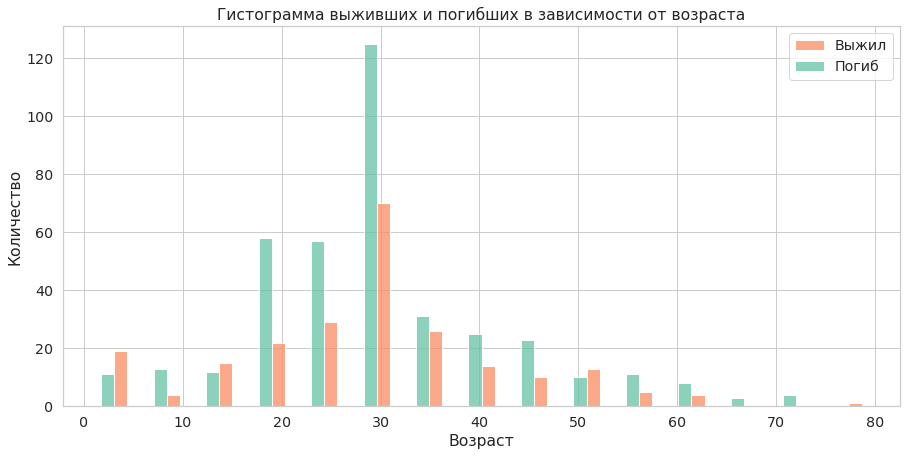

In [10]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(15, 7))
    ax = sns.histplot(data=x_train, x='Age', hue=y_train, multiple="dodge", shrink=.5, bins=15)
    plt.title('Гистограмма выживших и погибших в зависимости от возраста')
    plt.ylabel('Количество')
    plt.xlabel('Возраст')
    plt.legend(['Выжил', 'Погиб'])

Как видно из графика выше, по возрасту будет сложно сказать что-либо определённое, поэтому в корне решающего дерева 
будем рассматривать другой параметр.

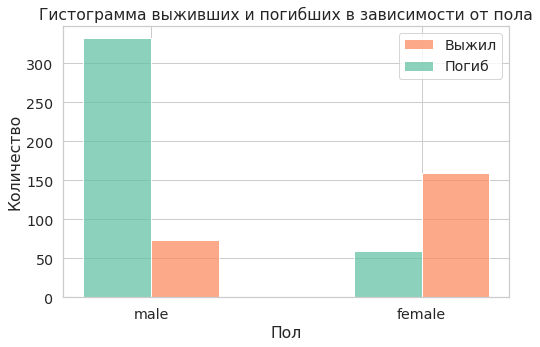

In [11]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=x_train, x='Sex', hue=y_train, multiple="dodge", shrink=.5)
    plt.title('Гистограмма выживших и погибших в зависимости от пола')
    plt.ylabel('Количество')
    plt.xlabel('Пол')
    plt.legend(['Выжил', 'Погиб'])

По полу разброс куда сильнее. Поэтому возьмём пол человека за основу и, соответственно, поставим его в корень нашего дерева. 

Но давайте дополнительно проверим зависимость от платы. Сразу разделим выборку на две части, чтобы увеличить читаемость графика

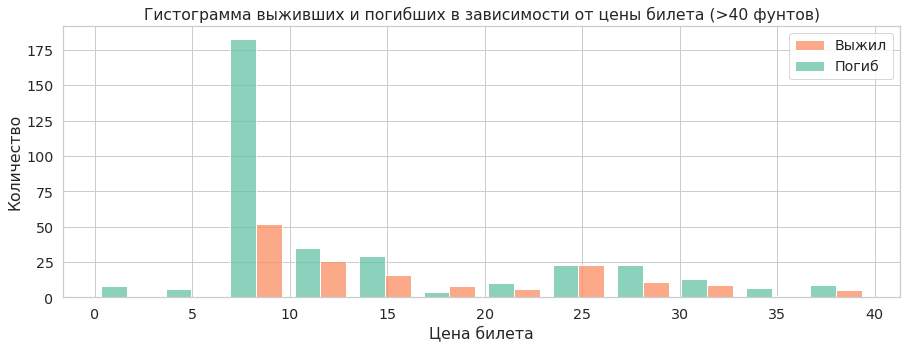

In [12]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(15, 5))
    sns.histplot(data=x_train[x_train['Fare']<40], x='Fare', hue=y_train, multiple="dodge", shrink=.8)
    plt.title('Гистограмма выживших и погибших в зависимости от цены билета (>40 фунтов)')
    plt.ylabel('Количество')
    plt.xlabel('Цена билета')
    plt.legend(['Выжил', 'Погиб'])

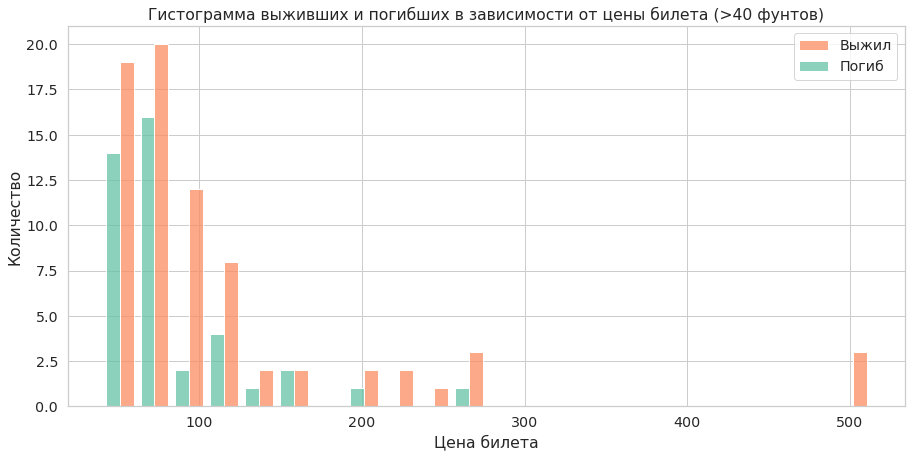

In [13]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(15, 7))
    sns.histplot(data=x_train[x_train['Fare']>=40], x='Fare', hue=y_train, multiple="dodge", shrink=.8)
    plt.title('Гистограмма выживших и погибших в зависимости от цены билета (>40 фунтов)')
    plt.ylabel('Количество')
    plt.xlabel('Цена билета')
    plt.legend(['Выжил', 'Погиб'])

Оказывается, выборка довольно неплохо делится и по этому параметру, ведь если человек брал билет дороже ~75 фунтов, то шансы выжить ощутимо увеличивались.

Посмотрим на долю выживших мужчин и женщин

In [14]:
train.groupby(by='Sex').mean()['Survived']

/tmp/ipykernel_23508/1489142629.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train.groupby(by='Sex').mean()['Survived']


Sex
female    0.729358
male      0.180247
Name: Survived, dtype: float64

Шанс того, что мужчина погиб ~ 80%, а что женщина выжила ~ 75%. И кажется, что логичнее будет пустить наиболее вероятный вариант в лист, но это не так. Когда спасали женщин, никто не спрашивал какой у них возраст или за какую цену они брали билет, поэтому разбиение выборки с девушками по какому-либо параметру будет очень неявным и только ухудшит точность предсказания. 

Теперь рассмотрим выборку мужчин и попробуем найти какую-либо закономерность в ней:

In [15]:
train_m = train[train['Sex']=='male']
x_train_m, y_train_m = get_features_and_target(train_m)

Посмотрим на возраст:

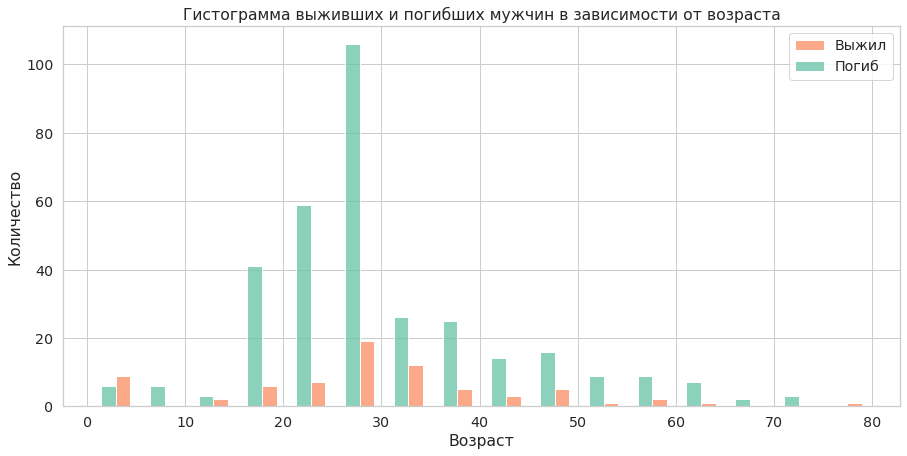

In [16]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(15, 7))
    ax = sns.histplot(data=x_train_m, x='Age', hue=y_train_m, multiple="dodge", shrink=.6, bins=16)
    plt.title('Гистограмма выживших и погибших мужчин в зависимости от возраста')
    plt.ylabel('Количество')
    plt.xlabel('Возраст')
    plt.legend(['Выжил', 'Погиб'])

Видно, что большинство людей старше 5 лет с большой вероятностью погибали, поэтому вторая вершина в первом дереве будет отвечать за возраст пассажира.

Теперь попробуем построить второе дерево, но пытаясь использовать при этом другие параметры, чтобы посмотреть на данные с другой стороны.

Как уже говорилось выше, стоит зацепиться за цену, которую пассажир платил за билет.

In [17]:
train_b40 = train[train['Fare']>=40]
train_l40 = train[train['Fare']<40]

x_train_b40, y_train_b40 = get_features_and_target(train_b40)
x_train_l40, y_train_l40 = get_features_and_target(train_l40)

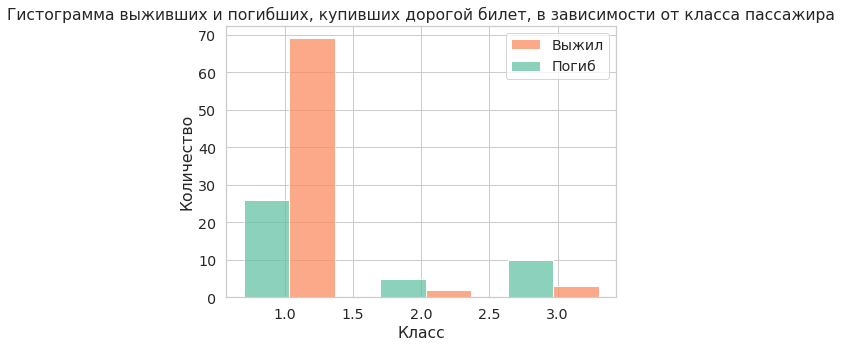

In [18]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(7, 5))
    ax = sns.histplot(data=x_train_b40, x='Pclass', hue=y_train_b40, multiple="dodge", shrink=10, bins=30)
    plt.title('Гистограмма выживших и погибших, купивших дорогой билет, в зависимости от класса пассажира')
    plt.ylabel('Количество')
    plt.xlabel('Класс')
    plt.legend(['Выжил', 'Погиб'])

В этом случае логично разделять по приналежности к 1му классу.



Аналогично посмотрим на данные пассажиров, потративших менее 40 фунтов на билет.

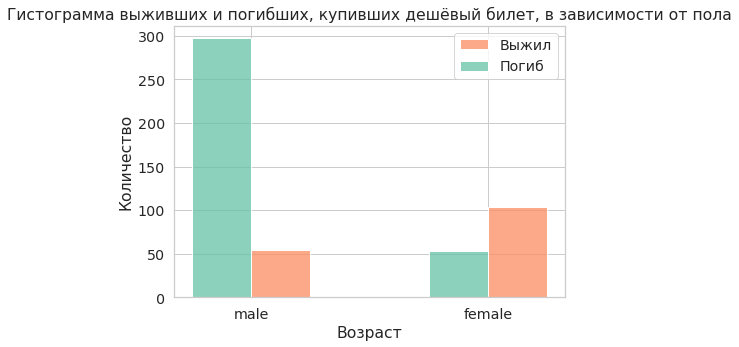

In [19]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(7, 5))
    ax = sns.histplot(data=x_train_l40, x='Sex', hue=y_train_l40, multiple="dodge", shrink=.5, bins=30)
    plt.title('Гистограмма выживших и погибших, купивших дешёвый билет, в зависимости от пола')
    plt.ylabel('Количество')
    plt.xlabel('Возраст')
    plt.legend(['Выжил', 'Погиб'])

А здесь, как оказывается, лучше всего отбирать по полу, так как другие показатели распределены более менее нормально.

#### 3. Классификация

На основе проведенного исследования предложите два разных правила в виде решающего дерева, пример которого можете посмотреть в презентации с первой лекции (классификация котиков). Никакие статистические методы использовать не требуется, только логику и графики.

В данной задаче достаточно, если первое дерево будет иметь максимальную глубину 2, а второе &mdash; глубину 1, и при этом не является поддеревом первого. *Примечание*: дерево из одного листа имеет глубину 0.

**Дерево 1:**

                                               Пол мужской?
                                             /              \               
                                        нет /                \ да
                                           /                  \
                                        Выжил           Возраст >5 лет?          
                                                        /            \
                                                   нет /              \ да
                                                      /                \
                                                   Выжил              Погиб
                                            


**Дерево 2:**

                                             Цена билета >75?
                                         /                      \               
                                    нет /                        \ да
                                       /                          \
                             Пол мужской?                         Пассажир 1го класса?          
                            /            \                          /            \
                       нет /              \ да                 нет /              \ да                       
                          /                \                      /                \
                       Выжил              Погиб                Погиб               Выжил                         
                                            

Реализуйте полученные деревья по шаблону

In [20]:
def tree(features):
    '''
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    Возвращает pandas.Series с теми же индексами, что и у features.
    '''
    predicted = (features['Sex']!='male') | (features['Age']<=5)
    return predicted

def tree_2(features):
    predicted = ((features['Fare']>75) & (features['Pclass']==1)) | ((features['Fare']<=75) & (features['Sex']=='female'))
    return predicted    

#### 4. Качество

Вспомним, что у нас имеется тестовая часть выборки. Самое время ее использовать для того, чтобы оценить, насколько хорошими получились деревья. Предложите какой-нибудь критерий качества.

*Замечание*. Не стоит пытаться искать, какие критерии существуют. В данном случае легко предложить адекватный критерий. Стандартные критерии мы разберем позже, но для начала лучше подумать самостоятельно.

**Критерий:**

В данной задаче нам важнее определить верно как можно больше выживших, а предсказать неправильно не так страшно. Например, если бы мы хотели снять документальный фильм об этой трагедии, поговорив с родственниками выживших тогда людей. 

Поэтому определим полноту наших предсказаний:

$$ criteria = \frac{survived\_true}{survived},$$


где survived_true $-$ количество выживших, верно определённых нашим классификатором, survived $-$ количество выживших всего.


Реализуйте данный критерий по шаблону

In [114]:
def criteria(target, predicted):
    '''
    Вычисление критерия качества для предсказания predicted, 
    если истинные значения -- target.
    Возвращает одно вещественное число.
    '''
    return target[predicted == 1].sum()/(target == 1).sum()

Посчитайте качество полученных ранее деревьев.

*Примечание.* Полученные значения не влияют на оценку по задание. Оценивается только корректность и обоснованность решения, а также графики и выводы.

In [167]:
print('Полнота по первому дереву:', criteria(y_test, tree(x_test)))
print('Полнота по второму дереву:', criteria(y_test, tree_2(x_test)))

Полнота по первому дереву: 0.7272727272727273
Полнота по второму дереву: 0.7


**5. Метод ближайшего соседа**

В домашнем задании 1 вы уже реализовали функцию поиска ближайших соседей. Теперь давайте применим ее для решения нашей текущей задачи. 

Реализуйте функцию, которая для каждого объекта тестового набора данных найдет $k$ ближайших соседей из обучающего набора данных, и в качестве ответа возьмет наиболее часто встречающееся значение целевого признака среди найденных соседей. Обратите внимание, что соседей необходимо искать только среди объектов обучающего набора данных.

Воспользуемся функцией, которую мы уже писали, а также напишем вспомогательные функции $-$ normalize и to_format, которые нормируют и форматируют данные для kNN:

In [162]:
def to_format(data):
    copy = data.copy()
    copy['Sex'] = copy['Sex'].apply(lambda s: int(s == 'male'))
    return np.array(copy)

def normalize(data):
    return (data - data.mean()) / (data.max() - data.min())


def find_nearest_points(A, B, k):
    n, m, d = A.shape[0], B.shape[0], B.shape[1] 
    _A = np.array([A]*m).reshape(m, n, d)
    _C = _A - B.reshape(m, 1, d) # right
    _C = _C.T
    
    _C = (_C*_C).sum(axis=0).T.reshape(m, n)
    return _C.argsort()[:, :k]

In [198]:
def knn(features, train_features, train_target, k=1):
    '''
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    на основе обучающего набора данных train_features, train_target.
    Возвращает pandas.Series с теми же индексами, что и у features.
    Число k -- количество соседей.
    '''
    # впоследствии выяснилось, что нормализация данных приводит к небольшому ухудшению результатов,
    # вероятно из-за того, что величина значений в столбцах и так неявно отвечает за взвешенность признака
    # поэтому в итоге от функции normalize пришлось отказаться

    features_norm = to_format(features)
    train_features_norm = to_format(train_features)

    k_neigh = find_nearest_points(train_features_norm, features_norm, k)
    predicted = np.array(train_target[k_neigh.flatten()]).reshape(-1, k).sum(axis = 1) >= k/2

    return pd.Series(data=predicted, index=features.index)

Посчитайте значение предложенного ранее критерия качества для метода ближайшего соседа для значений $k$ от 1 до 10. Постройте график зависимости критерия качества от $k$. Как вы можете пояснить полученные результаты?

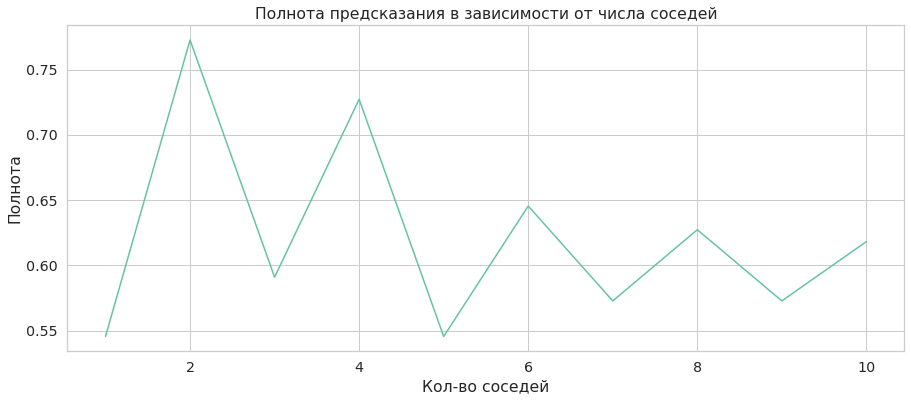

Наибольшая полнота 0.773   при k = 2


In [199]:
neigh = range(1, 11)
loss = []

for k in neigh:
    loss.append(criteria(y_test, knn(x_test, x_train, y_train, k)))

plt.figure(figsize=(15, 6))
plt.plot(neigh, loss)
plt.title("Полнота предсказания в зависимости от числа соседей")
plt.xlabel("Кол-во соседей")
plt.ylabel("Полнота")
plt.show()

print('Наибольшая полнота {0:0.3f} '.format(np.max(loss)), ' при k =', 1+np.argmax(loss))

Наибольшее качество мы получили при 2х соседях. Можно объяснить это плотностью данных по параметрам с маленькими значениями: класс, пол $-$ буквально небольшое смещение на 1 пункт может добавить в соседи людей, чьи шансы на выживание вырастали в несколько раз. 

#### 6. Выводы

Мы провели исследование пассажиров Титаника, чтобы понять, какие факторы повлияли на то, выжил человек или нет. Чаще всего старались спасти женщин и детей, а также пассажиров 1го класса. Результаты подтверждаются логикой, в первую очередь на спасательные шлюпки пускали именно это группы людей.

Также мы выбрали метрику и оценили её на двух моделях: решающем дереве и kNN, $-$ на которых она дала неплохие результаты.


---
### <font color="orange"><i>Сложная часть</i></font>

### Задача 2

<a target="_blank" href="yelp.com">Yelp</a> — веб-сайт для поиска на местном рынке услуг, например ресторанов или парикмахерских, с возможностью добавлять и просматривать рейтинги и обзоры этих услуг. Для популярных бизнесов имеются сотни обзоров. Для обозревателей на сайте предусмотрены элементы социальной сети.

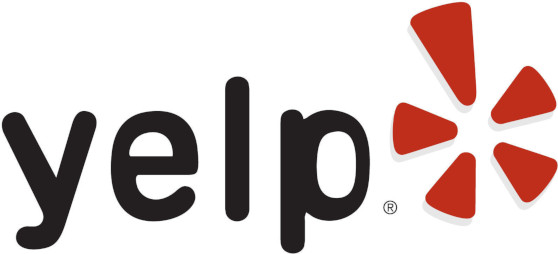

_____________

Вам предоставляется следующая информация о компаниях на Yelp:

Файл `yelp_business.csv`:
* `business_id` — уникальный идентификатор компании;
* `name` — имя компании;
* `address`, `city`, `state` — месторасположении компании;
* `latitude`, `longitude` — географические координаты;
* `categories` — категории услуг компании.

Файл `yelp_review.csv`, содержащий оценки пользователей:
* `business_id` — идентификатор компании, соответствующий файлу `yelp_business.csv`;
* `stars` — поставленная пользователем оценка от 1 до 5.

В целях сокращения объема файла, текстовые отзывы пользователей не были включены.

Оригинальную версию датасета в формате `json` можно посмотреть по <a target="_blank" href="https://www.kaggle.com/yelp-dataset/yelp-dataset/data">ссылке</a>.

_____________

**Что нужно сделать:** 

* Найти город с наибольшим количеством компаний;
* Для этого города определить районы с наиболее качественными услугами. <a target="_blank" href="https://yandex.ru/company/researches/2017/msk_mobile_map">Пример</a> с несколько другой задачей.
* А также найти рестораны с наилучшими отзывами.

------

#### Город с наибольшим количеством компаний

Загрузите данные из файла `yelp_business.csv` с помощью функции `pd.read_csv`. Посмотрите на первые несколько строк с помощью метода `head`.

In [66]:
df = pd.read_csv("yelp_business.csv", index_col=0)
df.head()

business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       85282   
4                    "581 Howe Ave"  Cuyahoga Falls    OH       44221   

    latitude   longitude  is_open  \
0  33.330690 -111.978599        1   
1  40.291685  -80.104900        1   
2  33.524903 -112.115310        1   
3  33.383147 -111.964725        0   
4  41.119535  -81.475690        1   

                                          categories  
0  Dentists;General Dentistry;Health & Medical;Or...  
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...  
2  Departments of Motor Vehicles;Public Services ...  
3                            Sporting Goods;Shopping  
4  American (New);Nightlife;Bars;Sandwiches;Ameri...

Найдите пять городов, по которым присутствует информация о наибольшем количестве компаний. В таблице должен быть указан город (название) и количество компаний в этом городе.

*Подсказка.* Для выполнения стоит воспользоваться методами `groupby`, `count`, `sort_values`, `head`.

In [67]:
city_comp = df[['city', 'is_open']].groupby(by='city').count().rename(columns={'is_open':'num_companies'}).reset_index().sort_values(by='num_companies', ascending=False).head()
city_comp

city  num_companies
424   Las Vegas          26775
713     Phoenix          17213
983     Toronto          17206
143   Charlotte           8553
871  Scottsdale           8228

Пусть `N` &mdash; город с наибольшим количеством компаний. Оставьте в таблице только записи, соответствующие городу `N`. Нанесите все эти компании на график, в котором по оси $x$ отметьте долготу, а по оси $y$ &mdash; широту.

<AxesSubplot: title={'center': 'Расположение компаний на карте'}, xlabel='Долгота', ylabel='Широта'>

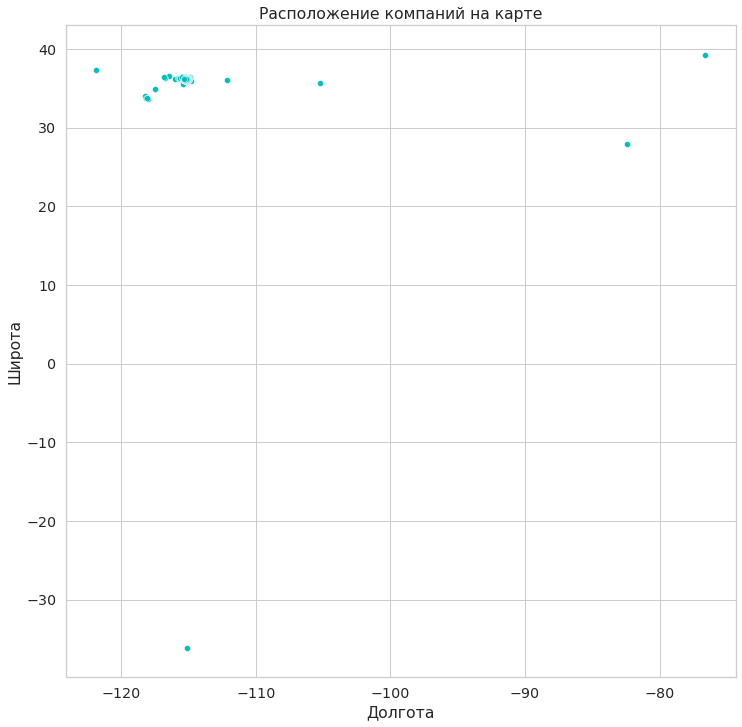

In [68]:
N = city_comp['city'].iloc[0]
city_comp = df[df['city']==N]

plt.figure(figsize=(12, 12))
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.title("Расположение компаний на карте")
sns.set_style(style='whitegrid')

sns.scatterplot(data = city_comp, x="longitude", y="latitude", color='c')

Сам город находится в сгустке точек. Есть какие-то компании, которые приписаны к этому городу, но находятся далеко от него. Избавьтесь от них, подобрав некоторые границы значений широты и долготы. Изобразите все компании на новом графике. На этом графике должны выделяться некоторые улицы. 

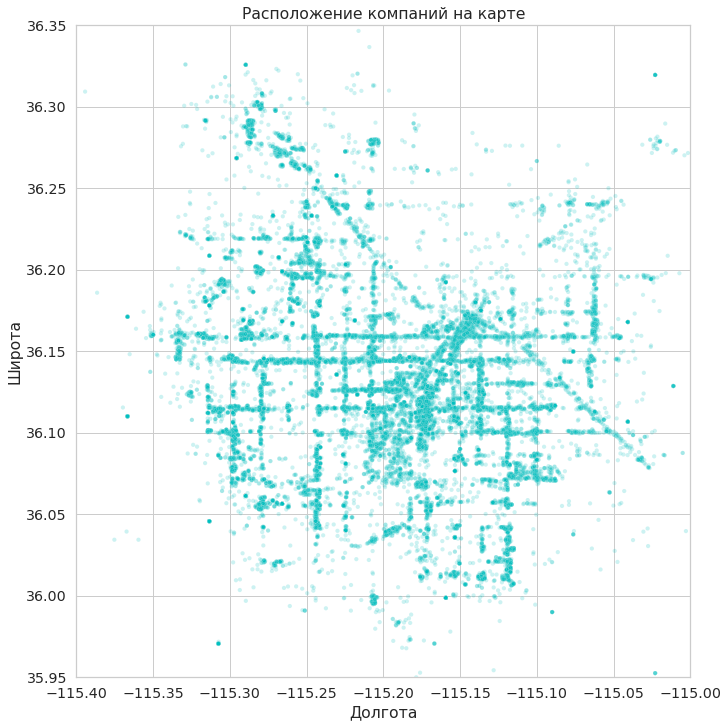

In [69]:
plt.figure(figsize=(11, 12))
plt.xlim(-115.4, -115)
plt.ylim(35.95, 36.35)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.title("Расположение компаний на карте")
sns.set_style(style='ticks')

scatter = sns.scatterplot(data=city_comp, x="longitude", y="latitude", alpha=0.2, color='c', size=35, legend=False)

Разберитесь с тем, как подгрузить интерактивную карту города в качестве фона графика. Можно пойти двумя следующими способами.
1. Изучить <a href="https://miptstats.github.io/courses/python/11_plotly.html" target="_blank">материалы</a> по библиотеке <a href="https://plotly.com/python/" target="_blank"><b>Plotly</b></a>. Возможно, потребуется также заглянуть в документацию.
1. Поразбираться с библиотекой <a href="https://github.com/python-visualization/folium" target="_blank"><b>Folium</b></a>. Посмотрите множество <a href="https://nbviewer.org/github/python-visualization/folium/tree/main/examples/" target="_blank">примеров</a>, может также помочь <a href="https://proglib.io/p/python-web-map" target="_blank">статья на русском</a>.

*Внимание!* Интерактивная карта может не сохраниться в ноутбуке, а если сохранится, то вес ноутбука может превзойти 20 Мб. Рекомендуется сохранить карту в html и отправить ее отдельным файлом в бот.

In [70]:
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [71]:
fig = px.scatter_mapbox(
    city_comp,  # таблица с данными
    lat='latitude', lon='longitude',  # колонки с координатами
    #z='Magnitude',  # колонки со значением исследуемой величины
    #radius=2,  # радиус влияния каждой точки
    center=dict(lat=36.125, lon=-115.17),  # центр карты
    zoom=9,  # масштаб карты
    mapbox_style="stamen-terrain",  # стиль карты
    opacity=0.3,
    title='Компании Лас-Вегаса'
)
fig.show()

In [72]:
plotly.offline.plot(fig, filename='map.html', auto_open=False)

'map.html'

Если все получилось, вы молодцы! Далее в этой задаче тоже можно делать интерактивные карты.

#### Оценки компаний

Для выполнения задания нужно посчитать среднюю оценку каждой компании, а также количество выставленных оценок.

Загрузите таблицу оценок `yelp_review.csv`.

In [73]:
review = pd.read_csv('yelp_review.csv', index_col=0)
review

business_id  stars
0        AEx2SYEUJmTxVVB18LlCwA      5
1        VR6GpWIda3SfvPC-lg9H3w      5
2        CKC0-MOWMqoeWf6s-szl8g      5
3        ACFtxLv8pGrrxMm6EgjreA      4
4        s2I_Ni76bjJNK9yG60iD-Q      4
...                         ...    ...
5261663  Ngk84Ax1tXgpoJFEGxot3w      1
5261664  pOEL97ld-FJMKO8Ki8JmYg      3
5261665  5ubokMNw8qfbX2WtxgJG1Q      4
5261666  EO3i5kTUG7_S2OIQ23sdSA      3
5261667  HloEEXm_QzEpycuwA_RtQA      3

[5261668 rows x 2 columns]

In [118]:
_review = review.groupby(by='business_id').aggregate([np.mean, np.size])
_review

stars      
                            mean  size
business_id                           
--6MefnULPED_I942VcFNA  3.135135    37
--7zmmkVg-IMGaXbuVd0SQ  3.851064    47
--8LPVSo5i0Oo61X01sV9A  4.333333     3
--9QQLMTbFzLJ_oT-ON3Xw  3.363636    11
--9e1ONYQuAa-CB_Rrw7Tw  4.088904  1451
...                          ...   ...
zzvlwkcNR1CCqOPXwuvz2A  3.000000     3
zzwaS0xn1MVEPEf0hNLjew  3.437500    64
zzwhN7x37nyjP0ZM8oiHmw  4.108108    37
zzwicjPC9g246MK2M1ZFBA  2.921569    51
zzzaIBwimxVej4tY6qFOUQ  3.432432    37

[174567 rows x 2 columns]

В подгруженной таблице оценок оставьте только компании города `N`. Для этого установите значения `business_id` в качестве индекса у таблицы оценок и воспользуйтесь методом `loc`. 

*Подсказка.* Чтобы индекс снова сделать полем таблицы, можно воспользоваться методом `reset_index`.

In [119]:
review = pd.read_csv('yelp_review.csv', index_col=1).drop('Unnamed: 0', axis=1)

In [120]:
city_comp = df[df['city']==N]
ids = city_comp['business_id']
_review = review.loc[ids].reset_index()

Теперь посчитайте среднюю оценку каждой компании, а также количество выставленных компании оценок. 

*Подсказка.* Помочь в этом могут функции `groupby` и `aggregate([np.mean, np.size])`.

In [121]:
_review = _review.groupby(by='business_id').aggregate([np.mean, np.size])
_review

stars      
                            mean  size
business_id                           
--9e1ONYQuAa-CB_Rrw7Tw  4.088904  1451
--DdmeR16TRb3LsjG0ejrQ  3.200000     5
--WsruI0IGEoeRmkErU5Gg  4.928571    14
--Y7NhBKzLTbNliMUX_wfg  4.875000     8
--e8PjCNhEz32pprnPhCwQ  3.473684    19
...                          ...   ...
zzOo9n22fBbKAhbSpMzggA  3.230769    26
zzXuJF6UUT1kgTyCsmgDmQ  5.000000     4
zzjqFOujmM9surbMANZ_ag  5.000000     3
zzsKbL1KMNJqazSqBXskxQ  3.666667     6
zzzaIBwimxVej4tY6qFOUQ  3.432432    37

[26775 rows x 2 columns]

Назовите колонки таблицы красивыми именами, изменив `<имя таблицы>.columns`, после чего напечатайте несколько строк полученной таблицы. Красивые имена &mdash; то, что будет понятно простому человеку при чтении ваших результатов. Как именно их назвать &mdash; задача аналитика, то есть в данном случае ваша :)

In [122]:
_review.columns = ['average_mark', 'marks_number']
_review

average_mark  marks_number
business_id                                       
--9e1ONYQuAa-CB_Rrw7Tw      4.088904          1451
--DdmeR16TRb3LsjG0ejrQ      3.200000             5
--WsruI0IGEoeRmkErU5Gg      4.928571            14
--Y7NhBKzLTbNliMUX_wfg      4.875000             8
--e8PjCNhEz32pprnPhCwQ      3.473684            19
...                              ...           ...
zzOo9n22fBbKAhbSpMzggA      3.230769            26
zzXuJF6UUT1kgTyCsmgDmQ      5.000000             4
zzjqFOujmM9surbMANZ_ag      5.000000             3
zzsKbL1KMNJqazSqBXskxQ      3.666667             6
zzzaIBwimxVej4tY6qFOUQ      3.432432            37

[26775 rows x 2 columns]

Соедините две полученные ранее таблицы по компаниям города `N` в одну.
Для этого сначала установите поле `business_id` в качестве индекса в обеих таблицах с помощью `set_index`. В одной из них это уже должно было быть сделано.
В полученной таблице должны получится поля `latitude`, `longitude`, `categories`, `name`, `stars`, `count`.

*Подсказка.* Соединение таблиц можно выполнить с помощью `join`.
Индексы у этих таблиц одинаковые, так что тип джойна не имеет значения.

In [123]:
data = city_comp.join(_review, on='business_id')
data.head()

business_id                 name   neighborhood  \
6   kCoE3jvEtg6UVz5SOD3GVw         "BDJ Realty"      Summerlin   
7   OD2hnuuTJI9uotcKycxg1A        "Soccer Zone"            NaN   
26  VBHEsoXQb2AQ76J9l8h1uQ  "Alfredo's Jewelry"      Southeast   
41  1Jp_hmPNUZArNqzpbm7B0g      "Task Electric"  Spring Valley   
48  DPQnTnNw2PJj7DdENM98Cw       "Star Nursery"            NaN   

                           address       city state postal_code   latitude  \
6       "2620 Regatta Dr, Ste 102"  Las Vegas    NV       89128  36.207430   
7   "7240 W Lake Mead Blvd, Ste 4"  Las Vegas    NV       89128  36.197484   
26       "5775 S Eastern, Ste 103"  Las Vegas    NV       89119  36.085051   
41     "7260 Cimarron Rd, Ste 130"  Las Vegas    NV       89113  36.056382   
48              "5340 Boulder Hwy"  Las Vegas    NV       89122  36.105196   

     longitude  is_open                                         categories  \
6  -115.268460        1  Real Estate Services;Real Estate;Home Services...   
7  -115.249660        1                            Shopping;Sporting Goods   
26 -115.119421        1       Shopping;Jewelry;Watch Repair;Local Services   
41 -115.269332        1  Home Services;Lighting Fixtures & Equipment;Lo...   
48 -115.056880        1       Nurseries & Gardening;Home & Garden;Shopping   

    average_mark  marks_number  
6       4.000000             5  
7       1.444444             9  
26      4.739130            23  
41      4.450000            20  
48      3.680000            25

Изобразите все компании на графике, раскрасив точку в цвет, оттенок которого соответствует средней оценке компании. Прозрачность точки выставляйте не более $0.3$.

In [124]:
fig = px.scatter_mapbox(
    data,  # таблица с данными
    lat='latitude', lon='longitude',  # колонки с координатами
    color='average_mark',  # колонки со значением исследуемой величины
    #radius=1,  # радиус влияния каждой точки
    center=dict(lat=36.125, lon=-115.17),  # центр карты
    zoom=9,  # масштаб карты
    mapbox_style="stamen-terrain",  # стиль карты
    color_continuous_scale=px.colors.sequential.Magma,
    opacity=0.2,
    title='Средняя оценка компаний Лас-Вегаса'
)
fig.show()

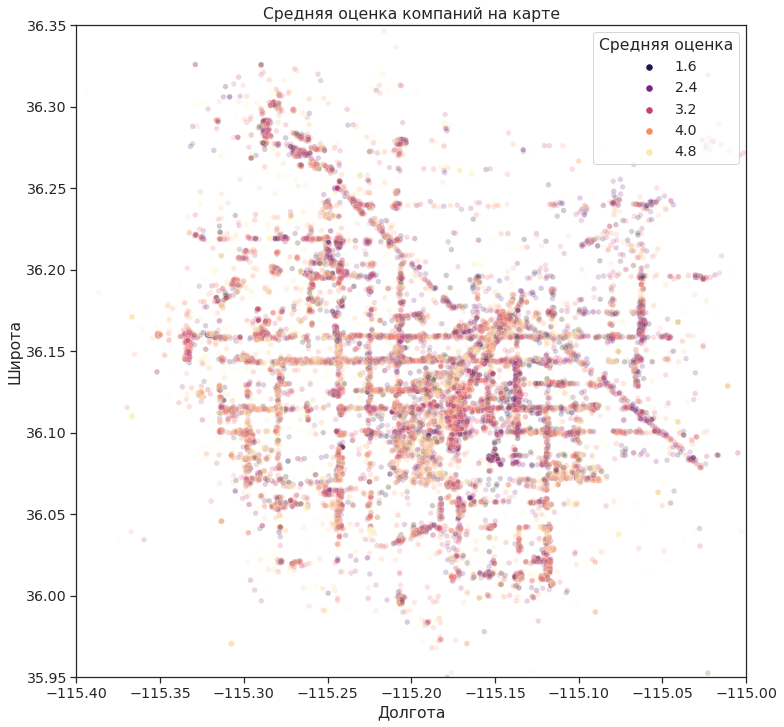

In [125]:
plt.figure(figsize=(12, 12))
plt.xlim(-115.4, -115)
plt.ylim(35.95, 36.35)
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.title("Средняя оценка компаний на карте")
sns.set_style(style='ticks')

scatter = sns.scatterplot(data=data, x=data["longitude"], y=data["latitude"], hue=data['average_mark'], palette='magma', alpha=0.2, size=data['average_mark'], sizes=(30, 30))
scatter.legend(title='Средняя оценка', loc='upper right')

Чтобы получить районы города, то есть разделить город на "клетки", округлите значения широты и долготы, подобрав оптимальный размер района. 

*Подсказка.* Например, можно сделать так
`np.round(долгота*4, decimals=1)*0.25`.

In [126]:
rating = data.copy()
rating['longitude'] = data['longitude'].apply(lambda x: 0.25*np.round(x*4, decimals=1))
rating['latitude'] = data['latitude'].apply(lambda y: 0.25*np.round(y*4, decimals=1))

Для получения средней оценки компании по району постройте сводную таблицу при помощи `pd.pivot_table`, взяв в качестве индексов и колонок округленные широту и долготу, а в качестве значений &mdash; оценки. Аггрегирующей функцией является среднее.

Изобразите полученную таблицу при помощи `sns.heatmap`.

Text(0.5, 1.0, 'Тепловая карта средней оценки компаний по району')

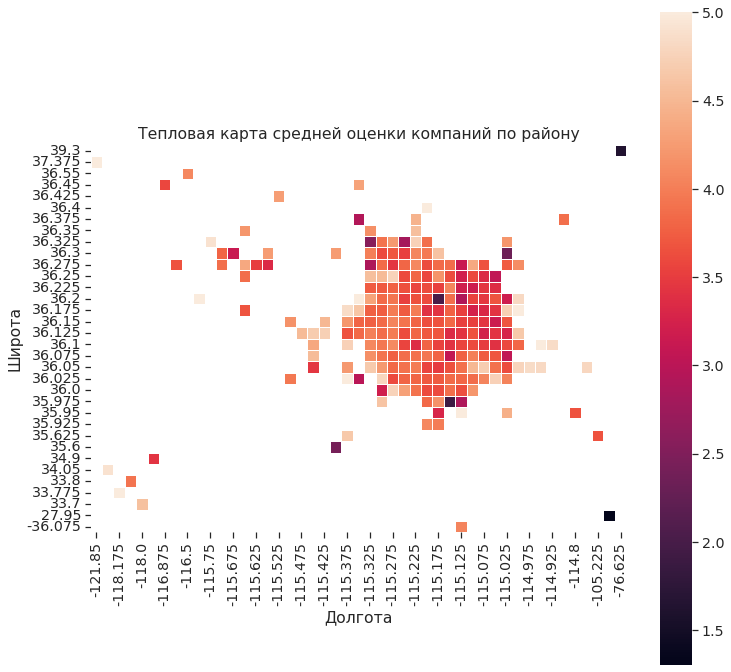

In [128]:
table = pd.pivot_table(rating, values='average_mark', index='latitude', columns='longitude', aggfunc=np.mean)

plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(table, square=True, linewidths=1)
heatmap.invert_yaxis()
heatmap.set_xlabel('Долгота')
heatmap.set_ylabel('Широта')
heatmap.set_title('Тепловая карта средней оценки компаний по району')

Полученный график имеет ряд недостатков. Во-первых, не очень правильно судить о районе, если в нем мало компаний. Во-вторых,  на графике цветовая гамма автоматически подстроилась под минимальное и максимальное значения оценки.

Почему эти недостатки могут быть существенными?

**Ответ:** 

1) Если в районе мало компаний, то одна-две компании с плохим рейтингом может сильно занизить рейтинг самого района, даже если плохой отзыв у них всего один, в то время как у компаний с высоким рейтингом хороших отзывов могут быть сотни; аналогично можно сказать и про завышение рейтинга района. Среднее значение средней оценки не всегда близко к среднему по району, тем более на нерепрезентативных выборках, поэтому их действительно можно не рассматривать. 


2) Когда человек смотрит на рейтинг, он практически не отличает 3 звезды от 2 или 1, поэтому все компании, у которых рейтинг ниже 3х, можно отправить в один класс.

Оставьте районы, в которых имеется информация о не менее $30$ компаний. Постройте новый график районов, использовав параметры `vmin` и `vmax` у функции `sns.heatmap`.

Text(0.5, 1.0, 'Тепловая карта средней оценки компаний по району')

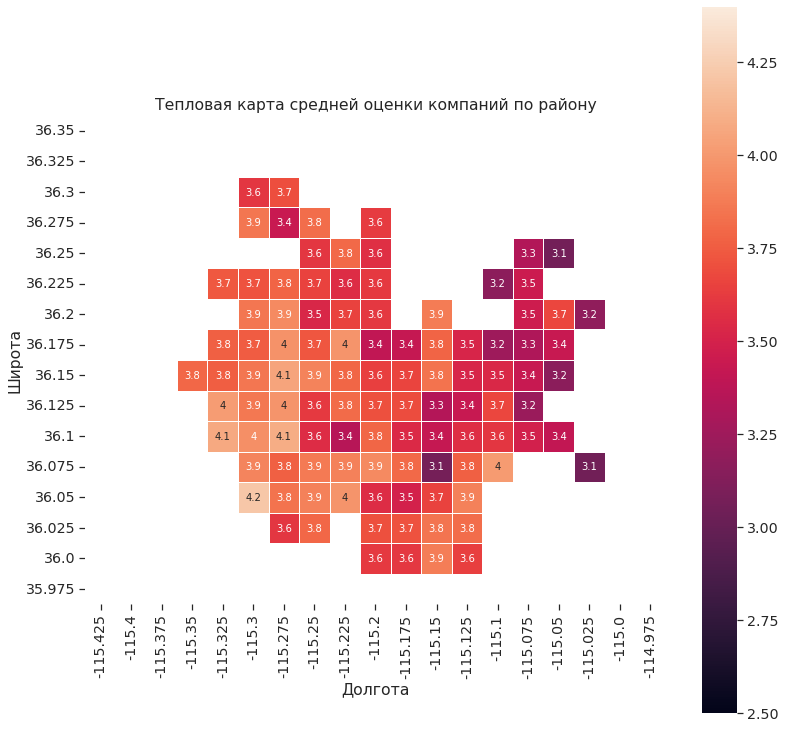

In [129]:
rating = rating[((data['latitude']>=35.96)&(data['latitude']<=36.35)&(data['longitude']>=-115.425)&(data['longitude']<=-114.975))]

table = pd.pivot_table(rating, values='average_mark', index='latitude', columns='longitude', aggfunc=np.mean)
mask = pd.pivot_table(rating, values='name', index='latitude', columns='longitude', aggfunc=np.size) < 30

plt.figure(figsize=(13, 13))
plt.xlim(-118, -114.8)
heatmap = sns.heatmap(table, vmin=2.5, vmax=4.4 ,square=True, linewidths=1, annot=True, mask=mask)
heatmap.invert_yaxis()
heatmap.set_xlabel('Долгота')
heatmap.set_ylabel('Широта')
heatmap.set_title('Тепловая карта средней оценки компаний по району')

Сравните полученный график с предыдущим и сделайте вывод.

**Вывод:** 

Видно, что при нашем разбиении на районы имеет смысл смотреть только на те, которые находятся ближе к центру города, где плотность компаний сильно больше. Практически все районы, что находятся в пригороде и уж тем более за многие километры от него, не наберут и 30 компаний, так как там понятие "район" теряется, ведь на выбранном месте может находиться, например, субурбия или буквально степь.

Поменяв границы оценки, можем сделать вывод, что средняя оценка покупателя достаточно низкая, причём чем восточнее мы находимся, тем она еще ниже.

#### Рестораны

Будем считать компанию рестораном, если в поле `categories` *содержится* слово `restaurant`. Обратите внимание, что в анализе данных часто нет четкого формата данных. Например, данное слово может быть написано как с большой буквы, так и с маленькой; может как разделяться `;`, так и не разделяться. При возникновении недопонимания стоит посмотреть данные.

Составьте таблицу, в которой будет информация о всех ресторанах города `N`, для которых имеется не менее $5$ отзывов. Далее постройте heatmap-график районов, в котором каждому району сопоставьте среднюю оценку по ресторанам этого района. Рассматривайте только те районы, в которых есть не менее $10$ ресторанов, для каждого из которых есть не менее $5$ отзывов.

Для начала напишем функцию, которая по категориям определяет, ресторан это или нет:

In [130]:
def is_restaurant(categories):
    return 'restaurant' in str(categories).lower()

In [131]:
features = ['business_id', 'name', 'city', 'latitude', 'longitude', 'categories', 'average_mark', 'marks_number']
rest = data[features]
rest = rest[data['marks_number']>=5]

rest['is_restaurant'] = rest['categories'].apply(lambda cat: is_restaurant(str(cat)))
rest = rest[rest['is_restaurant']==True]

rest.head()

business_id                                   name       city  \
52   Pd52CjgyEU3Rb8co6QfTPw              "Flight Deck Bar & Grill"  Las Vegas   
53   4srfPk1s8nlm1YusyDUbjg                               "Subway"  Las Vegas   
54   n7V4cD-KqqE3OXk0irJTyA                            "GameWorks"  Las Vegas   
122  Wpt0sFHcPtV5MO9He7yMKQ                           "McDonald's"  Las Vegas   
133  W1Yr6c2XDx_RBjb6WsV-aQ  "Divine Cafe at the Springs Preserve"  Las Vegas   

      latitude   longitude                                         categories  \
52   36.066914 -115.170848  Nightlife;Bars;Barbeque;Sports Bars;American (...   
53   36.064652 -115.118954                   Fast Food;Restaurants;Sandwiches   
54   36.068259 -115.178877  Arcades;Arts & Entertainment;Gastropubs;Restau...   
122  36.130013 -115.109310                      Restaurants;Fast Food;Burgers   
133  36.170706 -115.190288  Restaurants;Cafes;American (New);Bars;Nightlif...   

     average_mark  marks_number  is_restaurant  
52       3.769231            13           True  
53       2.666667             6           True  
54       3.117479           349           True  
122      2.150000            20           True  
133      4.050000           140           True

In [132]:
_rest = rest.copy()

_rest['longitude'] = _rest['longitude'].apply(lambda x: 0.25*np.round(x*4, decimals=1))
_rest['latitude'] = _rest['latitude'].apply(lambda y: 0.25*np.round(y*4, decimals=1))
_rest.head()

business_id                                   name       city  \
52   Pd52CjgyEU3Rb8co6QfTPw              "Flight Deck Bar & Grill"  Las Vegas   
53   4srfPk1s8nlm1YusyDUbjg                               "Subway"  Las Vegas   
54   n7V4cD-KqqE3OXk0irJTyA                            "GameWorks"  Las Vegas   
122  Wpt0sFHcPtV5MO9He7yMKQ                           "McDonald's"  Las Vegas   
133  W1Yr6c2XDx_RBjb6WsV-aQ  "Divine Cafe at the Springs Preserve"  Las Vegas   

     latitude  longitude                                         categories  \
52     36.075   -115.175  Nightlife;Bars;Barbeque;Sports Bars;American (...   
53     36.075   -115.125                   Fast Food;Restaurants;Sandwiches   
54     36.075   -115.175  Arcades;Arts & Entertainment;Gastropubs;Restau...   
122    36.125   -115.100                      Restaurants;Fast Food;Burgers   
133    36.175   -115.200  Restaurants;Cafes;American (New);Bars;Nightlif...   

     average_mark  marks_number  is_restaurant  
52       3.769231            13           True  
53       2.666667             6           True  
54       3.117479           349           True  
122      2.150000            20           True  
133      4.050000           140           True

После разбиения на районы построим тепловую карту с средней оценкой ресторанов.

In [133]:
_rest = _rest[((data['latitude']>=35.96)&(data['latitude']<=36.35)&(data['longitude']>=-115.5)&(data['longitude']<=-114.95))]

table = pd.pivot_table(_rest, values='average_mark', index='latitude', columns='longitude', aggfunc=np.mean)
mask1 = pd.pivot_table(_rest, values='name', index='latitude', columns='longitude', aggfunc=np.size) < 10
mask2 = pd.pivot_table(_rest, values='marks_number', index='latitude', columns='longitude', aggfunc=np.size) < 5

Text(0.5, 1.0, 'Тепловая карта средней оценки ресторанов по району')

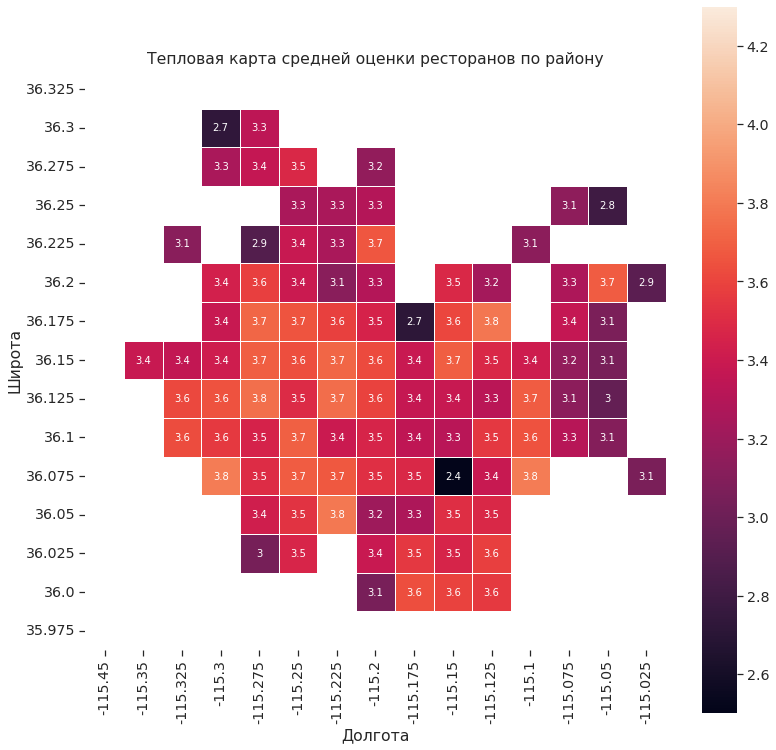

In [134]:
plt.figure(figsize=(13, 13))
heatmap = sns.heatmap(table, vmin=2.5, vmax=4.3 ,square=True, linewidths=1, annot=True, mask=mask1*mask2)
heatmap.invert_yaxis()
heatmap.set_xlabel('Долгота')
heatmap.set_ylabel('Широта')
heatmap.set_title('Тепловая карта средней оценки ресторанов по району')

Чем полезны ограничения снизу на количество отзывов для ресторана и количество ресторанов в районе?

**Ответ:**

Из-за ограничения на количество ресторанов выборка становится более репрезентативной по тем же соображениям, что и в предыдущем пункте. 

Количество отзывов позволяет более уверенно использовать средние значения для каждого ресторана, и, таким образом, среднее значение средней оценки гораздо лучше описывает реальность. 

Кот Василий из города `N` очень придирчив к выбору ресторана. Он доверяет только ресторанам с высоким рейтингом, который основывается на большом количестве отзывов. Напечатайте в виде таблицы информацию $10$ ресторанах с самым большим рейтингом в порядке убывания рейтинга. Для каждого из этих ресторанов должно быть не менее $50$ отзывов. По каждому ресторану необходимо вывести следующую информации: название ресторана, средняя оценка, количество отзывов, географические координаты, категории.

In [135]:
rest_feat = ['name', 'average_mark', 'marks_number', 'latitude', 'longitude', 'categories']
rest = rest[rest['marks_number']>=50].sort_values(by='average_mark', ascending=False)
rest_best = rest[rest_feat].iloc[:10]
rest_best

name  average_mark  marks_number   latitude  \
22863     "Lip Smacking Foodie Tours"      4.966480           179  36.114537   
165971                 "Pepito Shack"      4.907692            65  36.152477   
109391               "Bosa Boba Cafe"      4.890909            55  36.125960   
167803                 "Garden Grill"      4.868132            91  36.166783   
13577                  "Brew Tea Bar"      4.848069          1165  36.054195   
124895               "Poppa Naps BBQ"      4.836538           104  36.116549   
78897                "Zenaida's Cafe"      4.833333           180  36.101741   
78362    "El Frescos Cocina Mexicana"      4.816754           191  36.098527   
34418   "Blaqcat Ultra Hookah Lounge"      4.809524            63  36.159742   
154726     "California Sushi Burrito"      4.807018            57  36.125636   

         longitude                                         categories  
22863  -115.172678  Food Tours;Restaurants;Event Planning & Servic...  
165971 -115.151945  Restaurants;Burgers;Food Stands;Sandwiches;Hot...  
109391 -115.184846  Vietnamese;Bubble Tea;Sandwiches;Food;Coffee &...  
167803 -115.286197  Tacos;Street Vendors;Farmers Market;Vegetarian...  
13577  -115.242443  Cafes;Tea Rooms;Food;Bubble Tea;Restaurants;De...  
124895 -115.088115  Food Stands;Hot Dogs;Caterers;Restaurants;Amer...  
78897  -115.100359               Restaurants;Breakfast & Brunch;Cafes  
78362  -115.148446  Caterers;Mexican;Restaurants;Food;Event Planni...  
34418  -115.232738  Adult Entertainment;Lounges;Hookah Bars;Restau...  
154726 -115.202487  Asian Fusion;Fast Food;Restaurants;Japanese;Po...

Нанесите на карту все рестораны со средней оценкой не менее $4.7$, которая посчитана по не менее $50$ отзывам. Отдельным цветом отметьте 10 ресторанов, которые вы получили ранее.

In [136]:
rest_star = rest[rest['average_mark']>=4.7]
rest_star['top10'] = 0
rest_star['top10'].iloc[:10] = 1

rest_star['size'] = 1
rest_star['size'].iloc[:10] = 5
rest_star

business_id                                   name  \
22863   iBPyahdJRP5y0t25fF2W9w            "Lip Smacking Foodie Tours"   
165971  Fmij544FE1iOruoxI41kew                         "Pepito Shack"   
109391  qw9SyduMZ53KB6GlBQqvZQ                       "Bosa Boba Cafe"   
167803  k9b96JXlNewj36ddrce9Jw                         "Garden Grill"   
13577   IhNASEZ3XnBHmuuVnWdIwA                         "Brew Tea Bar"   
124895  k5ddmLvAKKw9zSusRPM2cQ                       "Poppa Naps BBQ"   
78897   8fFTJBh0RB2EKG53ibiBKw                       "Zenaida's Cafe"   
78362   l1GJnB9TJgGgEeI4at1M0A           "El Frescos Cocina Mexicana"   
34418   hFT3HuxVZJb1uYEsYfp-0A          "Blaqcat Ultra Hookah Lounge"   
154726  wZkjm9TGa7nXLYHxhIRO5w             "California Sushi Burrito"   
165247  1CaM8eIvl41l4f3V-V-cAw                          "Smooth Eats"   
14871   L1-1P3acJc4gEFvWwjXcNQ                   "Meraki Greek Grill"   
131783  9P23-V64kYz3trn9ecaJJA                         "Kame Omakase"   
152865  O7UMzd3i-Zk8dMeyY9ZwoA                       "Art of Flavors"   
101001  32JWhoH-Kiu1wRFTvHvW9Q                          "Pie Me Over"   
165775  E_jLyf_YuGgMP_rw8tvNSA               "Niko's Pizza Las Vegas"   
88388   GzBIAjAMHD9iVZK8BT6XMw                         "Tacos Huevos"   
101952  G03yt8WuN1v0bCD8mvoDiA                            "Fresh Sub"   
10954   3pSUr_cdrphurO6m1HMP9A                        "J Karaoke Bar"   
34051   zN4f3aLeCuIhCTPRH0di-A  "Salud Mexican Bistro and Tequileria"   
60231   QOE93SXgKd8EsaUT-DaXhA                   "Snow Ono Shave Ice"   
167674  vOMDU31gdylrzBhAKC9QbA     "Sushi Hiroyoshi Japanese Cuisine"   
136877  2B46bRpDh49eDyjXGhL_ZQ                  "La Maison de Maggie"   
144189  VONg0lyHm7fUdARWjkkjCQ                "Las Enchiladas Demama"   
141887  iX2c4IzH_L5F6FM5GD3SUQ                         "Tasty Crepes"   
38123   k0iSRXXqw49yugl8UUpbsw                           "Foodie Fit"   
109341  4Pl-ziYL2oerGyIPlwVdmA      "Chuchote Thai Bistro & Desserts"   
89490   1-Jdq5Up9SgKoqptGvkXHA                    "MVR Auto Services"   
16688   2hSIeCX2cV-chFcBBXrZZA                    "Pressed For Juice"   
174098  Tefx_N6A6nrsdj4jHHnbYg               "Le Petit Café & Bakery"   
161410  gjCmXkMNVE0JSk8puUwv6g                  "Eatt Gourmet Bistro"   
114529  U4ncU-YfIipnTetJDZLGlw                         "Gogo Poke LV"   
142775  mvLdgkwBzqllHWHwS-ZZgQ                                 "Elia"   
110157  ufmokEGxGqEWIdvIVsNg_Q        "Aria Mediterranean Restaurant"   
67179   4vm2W7J_ztH0vcX4bKfuXw                  "Sin Fronteras Tacos"   
56900   tMdgY7Ou4k3bYZZulJCiuQ            "Bronze Cafe at The Center"   
22513   Dcu698L9WArPRc9mAYrAzA                           "Sushi Hagi"   
49088   2QznyHGF0PuiYkrl5RU66A                      "Playa Papagayos"   
60424   LyVLSt5aLx-4Ll2XB-U-5Q     "Red Lantern Pho Vietnamese Grill"   

             city   latitude   longitude  \
22863   Las Vegas  36.114537 -115.172678   
165971  Las Vegas  36.152477 -115.151945   
109391  Las Vegas  36.125960 -115.184846   
167803  Las Vegas  36.166783 -115.286197   
13577   Las Vegas  36.054195 -115.242443   
124895  Las Vegas  36.116549 -115.088115   
78897   Las Vegas  36.101741 -115.100359   
78362   Las Vegas  36.098527 -115.148446   
34418   Las Vegas  36.159742 -115.232738   
154726  Las Vegas  36.125636 -115.202487   
165247  Las Vegas  36.167894 -115.140238   
14871   Las Vegas  36.098578 -115.242440   
131783  Las Vegas  36.194769 -115.252471   
152865  Las Vegas  36.151555 -115.152610   
101001  Las Vegas  36.078686 -115.241801   
165775  Las Vegas  36.106433 -115.298019   
88388   Las Vegas  36.159149 -115.152673   
101952  Las Vegas  36.114575 -115.226651   
10954   Las Vegas  36.126371 -115.191769   
34051   Las Vegas  36.142350 -115.268324   
60231   Las Vegas  36.169710 -115.123695   
167674  Las Vegas  36.159942 -115.222234   
136877  Las Vegas  36.127227 -115.279940   
144189  Las Vegas  36.101362 -115.120328  

In [137]:
fig = px.scatter_mapbox(
    rest_star,  # таблица с данными
    lat='latitude', lon='longitude',  # колонки с координатами
    color='top10',
    #radius=10,  # радиус влияния каждой точки
    center=dict(lat=36.125, lon=-115.17),  # центр карты
    zoom=10,  # масштаб карты
    mapbox_style="stamen-terrain",  # стиль карты
    color_continuous_scale=px.colors.sequential.Magma,
    range_color=[-0.05, 1],
    title='Рестораны Лас-Вегаса с рейтингом >4.7',
    height=600,
    size='size'
)
fig.show()

Охарактеризуйте кота Василия, а также сделайте общий вывод по задаче.

**Вывод:** 

Мы провели довольно объёмный анализ: выяснили, что самое большое количество компаний находится в Лас-Вегасе, научились строить интерактивные карты, а также разбили город по районам и рассмотрели среднюю оценку по каждому, причём грамотно отсеяли часть не репрезентативной выборки. Дополнительно мы сделали это и для ресторанов.

А кот Василий, который хочет найти один с лучших ресторанов, в следующий раз может расстроиться, если будет смотреть только на рейтинг отдельного ресторана, а не на средний рейтинг по району.